# Gaussian Process Regression in Pytorch

*Thomas Viehmann*, <tv@lernapparat.de>
Modelled after GPFlow Regression notebook by James Hensman


In [1]:
from matplotlib import pyplot
%matplotlib inline
import IPython
import torch
from torch.autograd import Variable
import numpy
import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

pyplot.style.use('ggplot')

In [2]:
import candlegp
import candlegp.training.hmc


Let's have a regression example

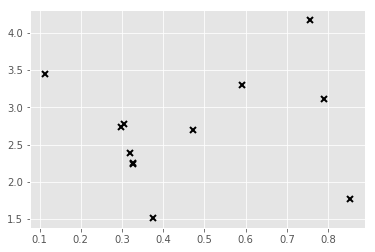

In [3]:
N = 12
X = torch.rand(N,1).double()
Y = (torch.sin(12*X) + 0.6*torch.cos(25*X) + torch.randn(N,1).double()*0.1+3.0).squeeze(1)
pyplot.figure()
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Creating the model

Not adapted to the data yet...

In [4]:
k = candlegp.kernels.Matern52(1, lengthscales=torch.DoubleTensor([0.3]),variance=torch.DoubleTensor([1.0]))
mean = candlegp.mean_functions.Linear(torch.DoubleTensor([1]), torch.DoubleTensor([0]))
m = candlegp.models.GPR(Variable(X), Variable(Y.unsqueeze(1)), kern=k, mean_function=mean)
m.likelihood.variance.set(0.01)
m

Parameter,Value,Prior,ParamType
mean_function.A,[[ 1.]],None,Param
mean_function.b,[ 0.],None,Param
kern.variance,[ 1.],None,PositiveParam
kern.lengthscales,[ 0.3],None,PositiveParam
likelihood.variance,[ 0.01],None,PositiveParam


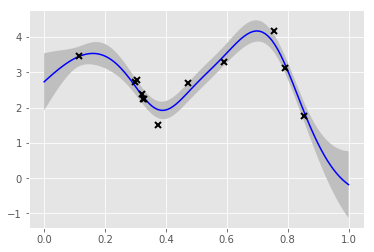

In [5]:
xstar = torch.linspace(0,1,100).double()
mu, var = m.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Maximum-A-Posteriori

One commonly used approach to model selection is to maximize the marginal log likelihood. This is the "gp" equivalent of a maximum-likelihood estimate.

In [6]:
opt = torch.optim.LBFGS(m.parameters(), lr=1e-2, max_iter=40)
def eval_model():
    obj = m()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(50):
    obj = m()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.data[0])
m

0 : 52.772171864187975
5 : 8.246478920681419
10 : 6.680809079047961
15 : 6.608956023145997
20 : 6.6069575651066845
25 : 6.606912459784613
30 : 6.6069116524963025
35 : 6.60691164788238
40 : 6.606911643709604
45 : 6.606911639931864


Parameter,Value,Prior,ParamType
mean_function.A,[[-0.27220916]],None,Param
mean_function.b,[ 2.95960583],None,Param
kern.variance,[ 0.67361498],None,PositiveParam
kern.lengthscales,[ 0.04826622],None,PositiveParam
likelihood.variance,[ 0.00209787],None,PositiveParam


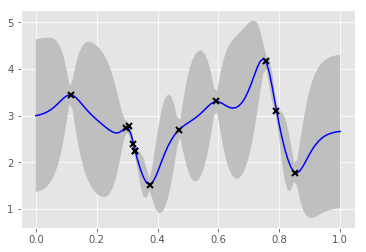

In [7]:
xstar = torch.linspace(0,1,100).double()
mu, var = m.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


## Hamiltonian Monte Carlo

We can go more Bayesian by putting a prior on the parameters and do Hamiltonian Monte Carlo to draw parameters.

In [8]:
k2 = candlegp.kernels.RBF(1, lengthscales=torch.DoubleTensor([0.3]),variance=torch.DoubleTensor([1.0]))
mean2 = candlegp.mean_functions.Linear(torch.DoubleTensor([1]), torch.DoubleTensor([0]))
m2 = candlegp.models.GPR(Variable(X), Variable(Y.unsqueeze(1)), kern=k2, mean_function=mean2)
m2.load_state_dict(m.state_dict())
m2.likelihood.variance.prior = candlegp.priors.Gamma(1.0,1.0,ttype=torch.DoubleTensor)
m2.kern.variance.prior = candlegp.priors.Gamma(1.0,1.0,ttype=torch.DoubleTensor)
m2.kern.lengthscales.prior = candlegp.priors.Gamma(1.0,1.0,ttype=torch.DoubleTensor)
m2.mean_function.A.prior = candlegp.priors.Gaussian(0.0,10.0, ttype=torch.DoubleTensor)
m2.mean_function.b.prior = candlegp.priors.Gaussian(0.0,10.0, ttype=torch.DoubleTensor)
print("likelihood with priors",m2().data[0])
m2

likelihood with priors 22.20831885195409


Parameter,Value,Prior,ParamType
mean_function.A,[[-0.27220916]],"N([ 0.],[ 10.])",Param
mean_function.b,[ 2.95960583],"N([ 0.],[ 10.])",Param
kern.variance,[ 0.67361498],"Ga([ 1.],[ 1.])",PositiveParam
kern.lengthscales,[ 0.04826622],"Ga([ 1.],[ 1.])",PositiveParam
likelihood.variance,[ 0.00209787],"Ga([ 1.],[ 1.])",PositiveParam


In [9]:
res = candlegp.training.hmc.hmc_sample(m2,500,0.2,burn=50, thin=10)

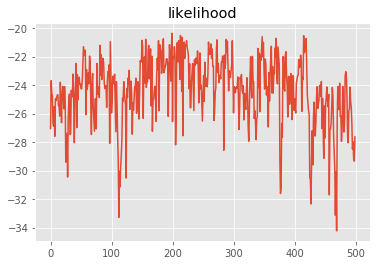

In [10]:
pyplot.plot(res[0]); pyplot.title("likelihood");

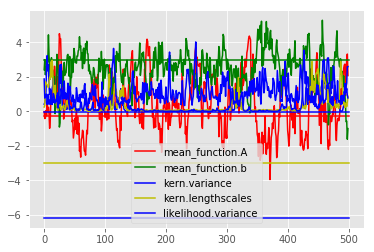

In [11]:
for (n,p0),p,c in zip(m.named_parameters(),res[1:],['r','g','b','y','b']):
  pyplot.plot(torch.stack(p).squeeze().numpy(), c=c, label=n)
  pyplot.plot((0,len(p)),(p0.data.view(-1)[0],p0.data.view(-1)[0]), c=c)
pyplot.legend();

## Plotting simulated functions

(Note that the simulations are for the de-noised functions - i.e. without the noise contribution of the likelihood.)

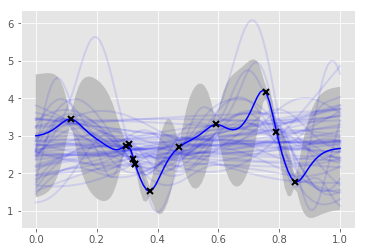

In [12]:
xstar = torch.linspace(0,1,100).double()
mc_params = torch.stack([torch.cat(p, dim=0) for p in res[1:]],dim=1)

allsims = []
for ps in mc_params[:50]:
    for mp,p in zip(m2.parameters(),ps):
        mp.set(p)
    allsims.append(m2.predict_f_samples(Variable(xstar.unsqueeze(1)), 1).squeeze(0).t())
allsims = torch.cat(allsims, dim=0)

pyplot.plot(xstar.numpy(),allsims.data.numpy().T, 'b', lw=2, alpha=0.1)

mu, var = m.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)
mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)


# Sparse Regression

In [13]:
k3 = candlegp.kernels.RBF(1, lengthscales=torch.DoubleTensor([0.3]),variance=torch.DoubleTensor([1.0]))
mean3 = candlegp.mean_functions.Linear(torch.DoubleTensor([1]), torch.DoubleTensor([0]))
m3 = candlegp.models.SGPR(Variable(X), Variable(Y.unsqueeze(1)), k3, X[:7].clone(), mean_function=mean3)
m3.likelihood.variance.set(0.01)
m3


Parameter,Value,Prior,ParamType
Z,[[ 0.7557373 ] [ 0.59180439] [ 0.11429469] [ 0.8527047 ] [ 0.29680875] [ 0.32735947] [ 0.32573381]],None,Param
mean_function.A,[[ 1.]],None,Param
mean_function.b,[ 0.],None,Param
kern.variance,[ 1.],None,PositiveParam
kern.lengthscales,[ 0.3],None,PositiveParam
likelihood.variance,[ 0.01],None,PositiveParam


In [14]:
opt = torch.optim.LBFGS(m3.parameters(), lr=1e-2, max_iter=40)
def eval_model():
    obj = m3()
    opt.zero_grad()
    obj.backward()
    return obj

for i in range(50):
    obj = m3()
    opt.zero_grad()
    obj.backward()
    opt.step(eval_model)
    if i%5==0:
        print(i,':',obj.data[0])
m3


RuntimeError: the number of sizes provided must be greater or equal to the number of dimensions in the tensor

In [ ]:
xstar = torch.linspace(0,1,100).double()
mu, var = m3.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)

mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)
pyplot.plot(m3.Z.data.numpy(), torch.zeros(m3.Z.size(0)).numpy(),'o')